# ACEA WATER ANALYSIS

In [1]:
import pandas as pd
import numpy as np
# %matplotlib notebook
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
from statsmodels.tsa.stattools import ccf
from scipy import stats

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('seaborn-muted')
plt.rcParams['font.family'] = 'Arial'

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
# Preprocessing functions

def preprocess(df, col_ind, start_ind=0):
    """
    Some basic preprocessing of data from selected column of dataframe.
    This will probably need to be thought about more to deal with NaNs
    more effectively
    
    """
    pd_series = df.iloc[start_ind:, col_ind]
    pd_values = pd_series.to_numpy()
    # max_value = np.max(np.abs(pd_values))
    # pd_values = pd_values / max_value
    name = df.columns[col_ind]
    
    return pd_values, name


def preprocess_int(df, col_ind, start_ind=0, fill_zeros=True):
    """
    Some basic preprocessing of data from selected column of dataframe.
    This will probably need to be thought about more to deal with NaNs
    more effectively
    
    """
    pd_series = df.iloc[start_ind:, col_ind]
    if fill_zeros:
        pd_series.replace(0, np.nan)
    pd_series = pd_series.interpolate(method='linear')
    pd_series = pd_series.fillna(method='bfill')
    pd_series = pd_series.fillna(method='ffill')
    pd_values = pd_series.to_numpy()
    # max_value = np.max(np.abs(pd_values))
    # pd_values = pd_values / max_value
    name = df.columns[col_ind]
    
    return pd_values, name


def get_time_series(col_inds, start_ind=0, fill_zeros=True):
    """
    Get all of the time series from the specified column indices and their names
    and populate lists for each
    
    """
    ts = []
    name = []
    
    for n in range(len(col_inds)):
        ts_, name_ = preprocess_int(df, col_inds[n], start_ind=start_ind, fill_zeros=fill_zeros)
        ts.append(ts_)
        name.append(name_)
        
    return ts, name


def find_data_gaps(dataframe, plot=True, title=None):
    """
    Finds NaNs and zeros in dataframe, with optional plot to show their locations
    
    """
    # Put dataframe into numpy array, ignoring date variable
    df_nodate = df.drop(['Date'], axis=1)
    all_data = df_nodate.to_numpy(na_value=np.nan)
    col_names = df_nodate.columns
    numcol = len(col_names)

    # Find missing values
    is_nan = np.isnan(all_data)
    is_zero = (all_data == 0)
    nan_array = np.where(is_nan, 1, np.nan)
    zero_array = np.where(is_zero, 1, np.nan)

    # Plot showing missing values and zeros
    if plot:
        if title is None: title = 'Location of NaNs and zeros in dataset'
        fig = plt.figure(figsize=(9, 5))
        ax = plt.subplot(111)
        # divider = make_axes_locatable(ax)
        # cax = divider.append_axes("top", size="5%", pad=0.08)
        norm = mpl.colors.Normalize(vmin=-1, vmax=1)
        sc_map = mpl.cm.ScalarMappable(norm=norm, cmap='PiYG')
        ms = ax.imshow(nan_array.T, aspect='auto', cmap='Pastel1', interpolation='none')
        ms2 = ax.imshow(zero_array.T, aspect='auto', cmap='Set3', interpolation='none')
        ax.set_yticks(np.arange(numcol))
        ax.set_yticklabels(col_names)
        ax.set_xlabel('Time [days]')
        cmap_nan = plt.cm.Pastel1
        cmap_zero = plt.cm.Set3
        custom_lines = [Line2D([0], [0], color=cmap_zero(0.), lw=5),
                        Line2D([0], [0], color=cmap_nan(0.), lw=5)]
        ax.legend(custom_lines, ['Zero', 'NaN'], loc='lower right')
        plt.title(title)
        plt.tight_layout()
        plt.show()
    
    return all_data, col_names, is_nan, is_zero


def normalise_sum(signal):
    """
    Normalises a signal so that the sum of all samples is unity.

    :param signal: An array of values representing the signal to be normalised.
    :returns: An array of values representing the normalised signal.

    """
    signal = np.asarray(signal, dtype=float)
    sum_ = np.sum(signal) if signal.any() else 1.

    return signal / sum_


def movingav(signal, winwidth, winfunc=None):
    """
    Calculates the moving average of a signal using chosen window function.

    :param signal: An array of values representing the signal to be smoothed.
    :param winwidth: The width of the smoothing window (number of samples).
    :param winfunc: The window function to use for smoothing. By default, a
        rectangular window will be used.
    :returns: An array of values representing the smoothed signal.
    :raises ValueError: If window width is negative.
    :raises ValueError: If window width exceeds length of input array.

    """
    numsamples = len(signal)

    hww = int(winwidth / 2.)
    winwidth = 2 * hww + 1

    if winwidth < 0:
        raise ValueError("window width must not be negative")

    if winwidth >= numsamples:
        raise ValueError("window width must not exceed length of input array")

    win = np.ones(winwidth) if winfunc is None else winfunc(winwidth)

    win = normalise_sum(win)

    halfwin2 = normalise_sum(win[hww:])
    halfwin1 = normalise_sum(win[:hww+1])

    valstart = np.dot(halfwin2, signal[0:hww+1])
    valend = np.dot(halfwin1, signal[numsamples - hww - 1:])

    signal = np.concatenate((np.ones(hww) * valstart, signal,
                             np.ones(hww) * valend))

    wpos = hww
    wend = len(signal) - hww - 1

    sig_smooth = np.empty(numsamples)

    while wpos <= wend:
        sig_smooth[wpos - hww] = np.dot(signal[wpos-hww: wpos+hww+1], win)
        wpos += 1

    return sig_smooth

In [4]:
# Statistical functions 

def spearman_lag(data1, data2, lag):
    """Calculate Spearman's rank correlation coefficient between 2 datasets,
    with a lag applied to data2"""
    
    data_length = data1.size
    if lag > 0:
        data2_lag = np.zeros(data_length)
        data2_lag[lag:] = data2[:-lag] 
        data2_lag[:lag] = data2[0]
    else:
        data2_lag = data2
    src, _ = stats.spearmanr(data1, data2_lag)
    
    return src


def cross_corr_lag(data1, data2, lag_array=None):
    """Calculate Spearman's rank correlation coefficient between 2 datasets,
    for a range of different lags applied to data2"""
    if lag_array is None:
        lag_array = np.arange(data1.size)
    crosscorr_lag = np.empty(len(lag_array))
    for n in range(len(lag_array)):
        crosscorr_lag[n] = spearman_lag(data1, data2, lag=lag_array[n])
        
    return crosscorr_lag, lag_array


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


def normalise_0_to_1(signal):
    sig_min = np.min(signal)
    sig_max = np.max(signal)
    sig_norm = (signal - sig_min) / (sig_max - sig_min)
    return sig_norm


def exp_convolve(data, tau, winlength=None):
    """
    Convolve input data with an exponential window function (time constant = tau)
    
    """
    data = np.asarray(data)
    len_data = data.size
    if winlength is None:
        winlength = len_data
    t = np.linspace(0, winlength-1, winlength)
    exp_window = np.exp(-t / tau)
    exp_window = exp_window / np.sum(exp_window)
    data_conv = np.convolve(data, exp_window, 'full')[:len_data]

    return data_conv


def find_datatypes(df):
    """Find the indices of each pf the different datatypes in the dataframe"""
    names = df.columns
    datatypes = ['Rainfall',
                 'Depth_to_Groundwater',
                 'Temperature',
                 'Volume',
                 'Hydrometry',
                 'Flow_rate',
                 'Lake_level']
    col_inds = []
    
    for n in range(len(datatypes)):
        col_ind_type = []
        for c in range(len(names)):
            if datatypes[n] in names[c]:
                col_ind_type.append(c)
        col_inds.append(col_ind_type)
        
    return datatypes, col_inds

In [5]:
# Plotting functions 

def plot_data_preprocessed(df, col_ind):
    data_ts, _ = preprocess(df, col_ind)
    data_ts_int, _ = preprocess_int(df, col_ind)
    data_ts_size = data_ts.size
    data_ts_int_size = data_ts_int.size
    time_array = np.linspace(0, data_ts_size-1, data_ts_size)
    time_array2 = np.linspace(0, data_ts_int_size-1, data_ts_int_size)
    plt.figure()
    plt.scatter(time_array, data_ts, s=0.2, alpha=0.6)
    plt.scatter(time_array2, data_ts_int, s=0.2, alpha=0.6)
    plt.show()
    

def plot_preprocessing(input_raw, input_pp, input_name, target_ts, target_name,
                       crop_min=1600, crop_max=2000, title=None):
    """
    Plot raw data and preprocessed data compared to target variable
    
    """
    cmap = plt.get_cmap('Dark2')
    colors = [cmap(i) for i in np.linspace(0, 1, 8)]
    len_data = input_raw.size
    fig, ax = plt.subplots(3, 2, sharey=True, figsize=(9, 4))
    y_max = 1.2
    
    ax[1, 0].set_ylim(0, y_max)
    ax[0, 0].plot(normalise_0_to_1(input_raw), color=colors[0], alpha=0.8)
    ax[1, 0].plot(normalise_0_to_1(input_pp), color=colors[1], alpha=0.8)
    ax[2, 0].plot(normalise_0_to_1(target_ts), color=colors[2], alpha=0.8)
    label1 = '{}, raw data'.format(input_name)
    label2 = '{}, pre-processed'.format(input_name)
    label3 = target_name
    ax[0, 1].text(0.01, 0.95, label1, transform=ax[0, 1].transAxes, va='top', ha='left')
    ax[1, 1].text(0.01, 0.95, label2, transform=ax[1, 1].transAxes, va='top', ha='left')
    ax[2, 1].text(0.01, 0.95, label3, transform=ax[2, 1].transAxes, va='top', ha='left')
    
    xmin = crop_min
    xmax = crop_max
    for n in range(3):
        ax[n, 0].plot([xmin, xmin], [0, y_max], 'k--', alpha=0.6)
        ax[n, 0].plot([xmax, xmax], [0, y_max], 'k--', alpha=0.6)
        ax[n, 0].set_xlim(0, len_data)
        ax[n, 1].set_xlim(xmin, xmax)
        con = mpl.patches.ConnectionPatch(xyA=[len_data, y_max/2], coordsA=ax[n, 0].transData,
                                          xyB=[xmin, y_max/2], coordsB=ax[n, 1].transData,
                                          arrowstyle='->')
        fig.add_artist(con)
        
    days = np.arange(xmin, xmax) 
    ax[0, 1].plot(days, normalise_0_to_1(input_raw)[xmin: xmax], color=colors[0], alpha=0.8)
    ax[1, 1].plot(days, normalise_0_to_1(input_pp)[xmin: xmax], color=colors[1], alpha=0.8)
    ax[2, 1].plot(days, normalise_0_to_1(target_ts)[xmin: xmax], color=colors[2], alpha=0.8)
    
    for n in range(2):
        ax[n, 0].axes.xaxis.set_ticklabels([])
        ax[n, 1].axes.xaxis.set_ticklabels([])
        ax[2, n].set_xlabel('Time [days]')
        
    if title is None:
        title = input_name + ' raw and pre-processed data, compared to ' + target_name
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    
    return


def plot_correl_matrix(data, names, title=None):
    """
    Plot cross-correlation matrix for input data, using Spearman's rank
    data should have shape: (num variables, num samples)
    names should be list of length (num variables)
    
    """
    # Calculate cross-correlation
    cross_corr, p_value = stats.spearmanr(data.T, nan_policy='omit')
    
    # Plot results
    numdata = len(names)
    if title is None:
        title = 'Cross-correlation matrix'
    fig = plt.figure(figsize=(9, 9))
    ax = plt.subplot(111)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.08)
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    sc_map = mpl.cm.ScalarMappable(norm=norm, cmap='PiYG')
    ms = ax.imshow(cross_corr, cmap='PiYG', interpolation='none', vmin=-1, vmax=1)
    fig.suptitle(title)
    ax.set_xticks(np.arange(numdata))
    ax.set_yticks(np.arange(numdata))
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    ax.xaxis.set_ticks_position('bottom')
    plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
             rotation_mode="anchor")
    plt.colorbar(mappable=sc_map, cax=cax)
    plt.tight_layout()
    plt.show()
      
    return


In [6]:
# tau analysis functions 

def find_tau_correlation(target_ts, rain_ts, tau_array=None):
    """
    Calculate convolution of rainfall data with an exponential window
    with time constant tau, for a range of values of tau.
    Then determine how correlated these convolved signals are to the
    target data by calculating Spearman's rank correlation coefficient
    for each value of tau
    
    """
    if tau_array is None:
        tau_array = np.linspace(2, 120, 60)
        
    rain_ts = np.asarray(rain_ts)
    target_ts = np.asarray(target_ts)
    winlength = rain_ts.size
    target_len = target_ts.size
    
    t = np.linspace(0, winlength-1, winlength)
    src = np.empty(len(tau_array))
    
    for n in range(len(tau_array)):
        exp_win = np.exp(-t/tau_array[n])
        rain_conv = np.convolve(rain_ts, exp_win, 'full')[:target_len]
        rain_conv = rain_conv / np.sum(exp_win)
        # if n==40:
        #     plt.figure()
        #     plt.plot(rain_ts, label='rain_ts')
        #     plt.plot(rain_conv, label='rain_conv')
        #     plt.plot(target_ts, label='target_ts')
        #     plt.legend()
        #     plt.show()
        src[n], _ = stats.spearmanr(target_ts, rain_conv)
        
    return src, tau_array


def find_best_tau(target_ts, rain_ts, plot=True, rain_name=None, target_name=None, tau_array=None):
    """
    Calculate correlation of convolved rainfall signal with the
    target signal for different time constants of exponential window
    and select the tau value that gives the best correlation.
    Optional plot of correlation for different tau values.
    
    """
    tau_best = []
    src_best = []
    if plot: plt.figure()
    for n in range(len(rain_ts)):
        src, tau_array = find_tau_correlation(
                                normalise_0_to_1(target_ts),
                                normalise_0_to_1(rain_ts[n]),
                                tau_array=tau_array)
        tau_best.append(tau_array[np.argmax(src)])
        src_best.append(src[np.argmax(src)])
        if plot: plt.plot(tau_array, src, label=rain_name[n], lw=1.5, alpha=0.7)  
            
    if plot:
        plt.xlabel("Time constant (tau) for convolution with exponential window")
        plt.ylabel("Spearman's Rank correlation coefficient")
        title_text = 'Correlation of convolved rainfall data with {} for different tau values'.format(target_name)
        plt.title(title_text, wrap=True)
        plt.ylim(0, 1)
        plt.legend(fontsize=9)
        plt.tight_layout()
        plt.show()
        
    return tau_best, src_best


def find_all_best_tau(input_ts, input_name, target_ts, target_name):
    """
    Calculating optimum tau for each input/target combination that
    maximises the Spearman's Rank correlation coefficient when the input is
    convolved with an exponential window (time constant tau)
    
    """
    # Find best tau values
    all_tau_best = []
    all_src_best = []
    for n in range(len(target_ts)):
        if n == 0:
            tau_array = np.linspace(240, 2200, 50)
        else:
            tau_array = None
        tau_best, src_best = find_best_tau(target_ts[n], input_ts, plot=False,
                                           tau_array=tau_array)
        all_tau_best.append(tau_best)
        all_src_best.append(src_best)
    all_tau_best = np.asarray(all_tau_best)
    all_src_best = np.asarray(all_src_best)

    # Plot results
    fig = plt.figure()
    ax = plt.subplot(111)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=0.3, pad=0.08)
#     cbar_min = np.min(all_tau_best)
#     cbar_max = np.max(all_tau_best[1:, :]) + 5
    cbar_min = 0
    cbar_max = 1
    norm = mpl.colors.Normalize(vmin=cbar_min, vmax=cbar_max)
    sc_map = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
    ms = ax.imshow(all_src_best, norm=norm, cmap='viridis',
                   vmin=cbar_min, vmax=cbar_max)
    for i in range(len(target_name)):
        for j in range(len(input_name)):
            if (cbar_max - all_tau_best[i, j]) / (cbar_max - cbar_min) < 0.2:
                text_col = 'k'
            else:
                text_col = 'w'
            text = ax.text(j, i, np.int(all_tau_best[i, j]),
                           ha="center", va="center", color=text_col,
                           fontsize=8)
    fig.suptitle('Optimum Tau value for exponential window')
    ax.set_xticks(np.arange(len(input_name)))
    ax.set_yticks(np.arange(len(target_name)))
    ax.set_xticklabels(input_name)
    ax.set_yticklabels(target_name)
    ax.xaxis.set_ticks_position('bottom')
    plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
             rotation_mode="anchor")
    plt.colorbar(mappable=sc_map, cax=cax, extend='max')
    plt.tight_layout()
    plt.show()

    return all_tau_best


def tau_and_lag_correl(target_ts, rain_ts, lag_array=None, tau_array=None,
                       plot=True):
    """
    Calculate correlation coefficients for different time lag and tau
    values for rainfall. Optional plot.

    """
    # Set default lag and tau values to analyse
    if lag_array is None:
        lag_array = np.arange(20)
    if tau_array is None:
        tau_array = np.linspace(22, 90, 35).astype(np.int)
        
    # Calculate Spearman's Rank coefficient for each tau and lag combination
    sp_rank_cc = []
    for n in range(len(lag_array)):
        lag = lag_array[n]
        data_length = rain_ts.size
        if lag > 0:
            data_lag = np.zeros(data_length)
            data_lag[lag:] = rain_ts[:-lag]
            data_lag[:lag] = rain_ts[0]
        else:
            data_lag = rain_ts
        src, _ = find_tau_correlation(target_ts, data_lag,
                                      tau_array=tau_array)
        sp_rank_cc.append(src)
    sp_rank_cc = np.asarray(sp_rank_cc)
    
    # Plot matrix showing correlation for each tau and lag combination
    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(sp_rank_cc)
        fig.colorbar(cax)
        ax.set_xticks(np.arange(len(tau_array)))
        ax.set_yticks(np.arange(len(lag_array)))
        ax.set_xticklabels(tau_array)
        ax.set_yticklabels(lag_array)
        ax.xaxis.set_ticks_position('bottom')
        plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
                 rotation_mode="anchor")
        ax.set_xlabel('Tau for exponential window')
        ax.set_ylabel('Time lag [days]')
        plt.title('Correlation of rainfall with target for different values of tau and time lag')
        fig.show()
        
    return sp_rank_cc, lag_array, tau_array

In [7]:
# Volume pre-processing

def preprocess_vol(vol_data, smooth_amt_1=800, smooth_amt_2=30):
    """Pre-process volume data by smoothing, calculating deviation from the smoothed data,
    and then smoothing again"""
    deviation = vol_data - movingav(vol_data, smooth_amt_1, winfunc=np.hanning)
    smoothed = movingav(deviation, smooth_amt_2, winfunc=np.hanning)
    return normalise_0_to_1(smoothed)
    

def find_best_vol_params(vol_ts, target_ts, smoothing_1=None, smoothing_2=None, plot=True):
    """Calculate the correlation of the preprocessed volume data with the target data for
    different lengths of smoothing window, in order to find the most appropropriate settings"""
    if smoothing_1 is None:
        smoothing_1 = np.linspace(50, 2000, 40).astype(np.int)
    if smoothing_2 is None:
        smoothing_2 = np.linspace(2, 40, 20).astype(np.int)
    num_smth_1 = smoothing_1.size
    num_smth_2 = smoothing_2.size
    coeffs = np.empty((num_smth_1, num_smth_2))
    for i in range(num_smth_1):
        for j in range(num_smth_2):
            vol_processed = preprocess_vol(vol_ts, smooth_amt_1=smoothing_1[i],
                                           smooth_amt_2=smoothing_2[j])
            corr_coeff, _ = stats.spearmanr(vol_processed, target_ts)
            coeffs[i, j] = corr_coeff
    
    if plot:
        plt.figure()
        ax = plt.subplot(111)
        im = ax.imshow(coeffs.T)
#         norm = mpl.colors.Normalize(vmin=0, vmax=1)
#         sc_map = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
#         plt.colorbar(mappable=sc_map)
        ax.figure.colorbar(im, ax=ax)
        ax.set_xticks(np.arange(num_smth_1))
        ax.set_yticks(np.arange(num_smth_2))
        ax.set_xticklabels(smoothing_1)
        ax.set_yticklabels(smoothing_2)
        ax.xaxis.set_ticks_position('bottom')
        plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
                 rotation_mode="anchor")
        plt.show()
        
    return


In [8]:
# LSTM functions 

def compile_model_input_variables(model_rain_ind,
                                  model_vol_ind,
                                  model_temp_ind,
                                  model_hydro_ind,
                                  rain_pp,
                                  vol_pp,
                                  temp_pp,
                                  hydro_pp):
    """
    Extract the selected variables from the preprocessed data by their indices
    and populate an input array to be used by the model.
    The input array will have shape: (num features, num timesteps)
    
    """    
    num_inputs = len(model_rain_ind) + len(model_vol_ind) + \
                 len(model_temp_ind) + len(model_hydro_ind)
    num_timesteps = rain_pp[0].size
    model_input_data = np.empty((num_inputs, num_timesteps))
    count = 0
    for i in model_rain_ind:
        model_input_data[count, :] = rain_pp[i]
        count += 1
    for i in model_vol_ind:
        model_input_data[count, :] = vol_pp[i]
        count += 1
    for i in model_temp_ind:
        model_input_data[count, :] = temp_pp[i]
        count += 1
    for i in model_hydro_ind:
        model_input_data[count, :] = hydro_pp[i]
        count += 1
#     model_rain_data = np.asarray([rain_pp[i] for i in model_rain_ind])
#     model_vol_data = np.asarray([vol_pp[i] for i in model_vol_ind])
#     model_temp_data = np.asarray([temp_pp[i] for i in model_temp_ind])
#     model_hydro_data = np.asarray([hydro_pp[i] for i in model_hydro_ind])
    
    return model_input_data


def create_dataset(dataset, look_back=1, chunk_step=1, predict_steps=1):
    """
    Convert data set into a dataset matrix by splitting the data into a number of 'chunks'
    that are randomly ordered. Each chunk has an input (x) of length 'look_back', and an
    output (y) of length 'predict_steps'. The indices of each chunk within the original array
    are stored in 'y_ind'.
    The shape of the input and output arrays is as follows:
    dataset: (num features, num timesteps)
    x:       (num chunks, look_back, num features)
    y:       (num chunks, predict_steps)
    y_ind:   (num chunks)
    
    """
    numchunk = int(np.floor((dataset.shape[1] - look_back - 1) / chunk_step))
    dataX = np.empty((numchunk, look_back, dataset.shape[0]))
    dataY = np.empty((numchunk, predict_steps))
    y_ind = []
    
    # Create chunks of data with the specified look back
    for i in range(numchunk):
        start_ind = chunk_step*i
        dataX[i, :, :] = dataset[:, start_ind:(start_ind + look_back)].T
        dataY[i, :] = dataset[0,start_ind+look_back:start_ind+look_back+predict_steps] #MG
        #dataY.append(dataset[0, start_ind + look_back])
        y_ind.append(start_ind + look_back)
        
    # Randomise order of chunks
    rand_indices = np.random.permutation(numchunk)
    x = np.array(dataX)
    y = np.array(dataY)
    y_ind = np.array(y_ind)
    x = x[rand_indices, :]
    y = y[rand_indices,:]
    #y = np.reshape(y, (y.size, 1)) # MG
    y_ind = y_ind[rand_indices]
    
    return x, y, y_ind

# Aquifier Auser
## Data pre-processing
### Handling missing data
First, the data was read in and an analysis of missing data was carried out.


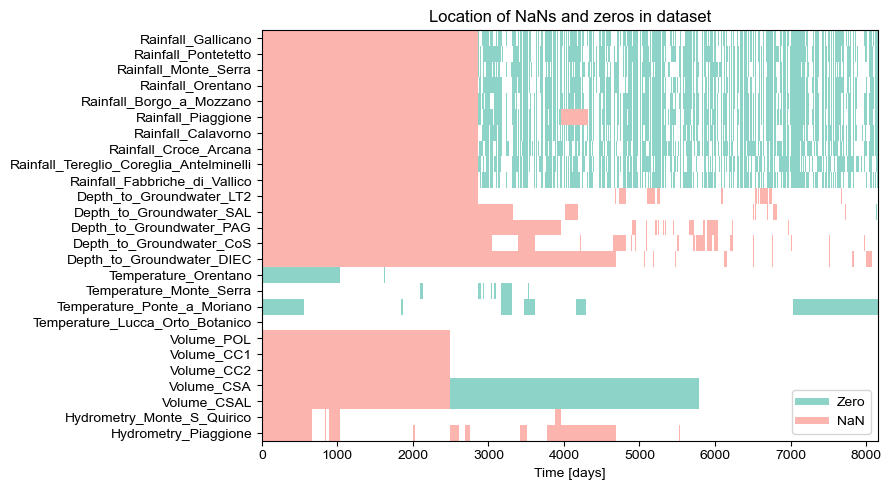

In [9]:
# Pre-processing data

# Importing all data into pandas dataframe
foldpath = r"acea-water-prediction"
files = list(Path(foldpath).rglob('*.csv'))
df = pd.read_csv(files[0])

# Find and plot gaps in the data
all_data, col_names, is_nan, is_zero = find_data_gaps(df, plot=True, title=None)


The plot above shows that there is a significant amount of data missing over the total time period, either in the form of NaNs, or zeros. In the case of the rainfall data, the zeros are considered to be 'real data' since there are many days with zero rainfall, however for the other data it is assumed that zeros imply missing data.

When deciding how to handle these gaps in the data, the aim was to find a compromise between maintaining as much of the original data as possible, and not introducing too much inaccuracy from filling in the gaps. For each variable, we consider a combination of three different options for handling these gaps:
1. Crop the entire dataset over a certain time range to avoid the gaps. If many of the variables contain missing data for the same time period, then this option is sensible as this time period is unlikely to be useful for the model.
2. Remove the variable completely. This may be necessary if there is missing data for large time periods, particularly if many other variables contain data in those time periods. For example, 'Volume_CSA' and 'Volume CSAL' both contain large gaps in the data where there is data for most other variables (from days ~3000-6000, so it makes sense to remove these from the analysis.
3. Fill in the missing data for that variable by prediction (e.g. interpolation, backpropagation). Where the gaps in the data are relatively short and make up a small proportion of the total data, this option is likely to be preferable.

Since there are NaNs in most of the data for the first ~3000 days, including all of the target variables, it was decided that this time period would not be used for the model at all.


In [10]:
# Find column indices for different datatypes
datatypes, col_inds = find_datatypes(df)

# Get time series data for all variable types
start_ind = 3955
rain_ts, rain_name = get_time_series(col_inds[0], start_ind=start_ind, fill_zeros=False)
target_ts, target_name = get_time_series(col_inds[1], start_ind=start_ind)
temp_ts, temp_name = get_time_series(col_inds[2], start_ind=start_ind)
vol_ts, vol_name = get_time_series(col_inds[3], start_ind=start_ind)
hydro_ts, hydro_name = get_time_series(col_inds[4], start_ind=start_ind)  


In [11]:
# Remove zeros from target
# N.B. SHOULD REPLACE THIS WITH A DIFFERENT METHOD
for m in range(len(target_ts)):
    for n in range(len(target_ts[m])):
        if n > 0 and target_ts[m][n] == 0:
            target_ts[m][n] = target_ts[m][n-1]

# Extend target with 2 values missing from the end
# to_append = target_ts[1][-1]*np.ones(2)
# target_ts[1] = np.append(target_ts[1], target_ts[1][-1]*np.ones(2), 0)


### Rainfall
Rainfall was expected to be one of the most useful variables in predicting groundwater levels, since it is one the key physical mechanisms that drives the inflow of water into aquifiers. From a visual inspection of the data, it was clear that many of the peaks in rainfall correspond approximately to peaks in the groundwater level. This was seen to apply both to the longer term trend, as well as on a smaller day-by-day scale. However, while the peaks in rainfall are often immediately followed by days of zero rainfall, the peaks in the groundwater data seem to decay more slowly over time.

This led to the hypothesis that the rainfall on a particular day adds to the groundwater level relatively quickly, and then this level decays more slowly over several weeks. The physical explanation for this seems to be logical - if the rate of the rainfall is significantly larger than the rate that the water drains out of the groundwater subsystem, then the level will rise quickly and fall slowly (similar to the level of a slowly leaking cup when water is poured into it). For shallower subsystems, we may expect to see more short term reactions to the rainfall, as it would reach the subsystem more quickly and drain out more quickly; and conversely for deeper subsystems, we would expect the levels to react more slowly, with smaller short term effects.

To test this hypothesis, the rainfall data was convolved with an exponential window function, for a range of different time constants. The correlation of these convolved signals with the 'depth to groundwater' variables was calculated to find the time constant that gave the best correlation for each combination of variables.

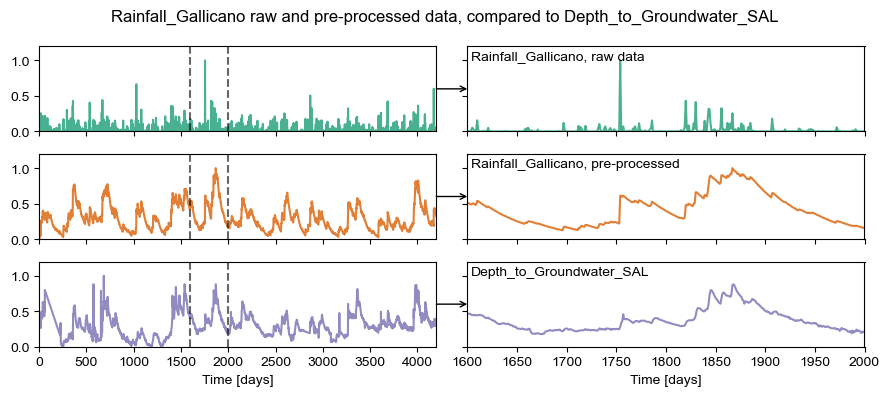

In [12]:
# Rainfall data analysis

r_i = 0
t_i = 1
rain_pp = exp_convolve(rain_ts[r_i], tau=54)
plot_preprocessing(rain_ts[r_i], rain_pp, rain_name[r_i], target_ts[t_i], target_name[t_i],
                   crop_min=1600, crop_max=2000, title=None)


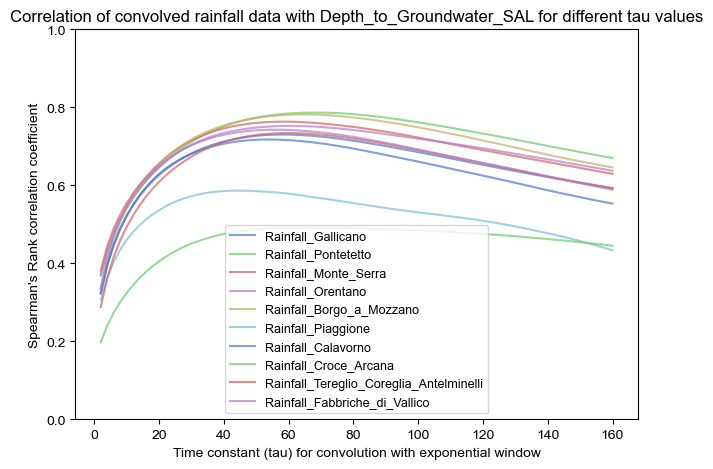

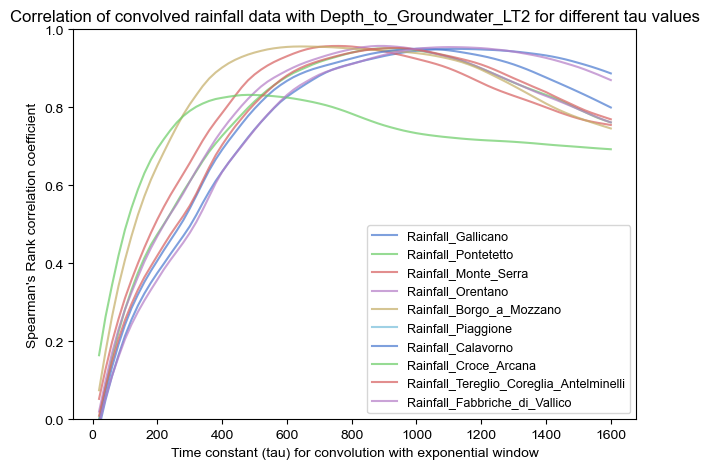

In [13]:
# Plot example of correlation for different tau values

tau_best, src_best = find_best_tau(target_ts=target_ts[1], rain_ts=rain_ts,
                         rain_name=rain_name, plot=True,
                         target_name=target_name[1],
                         tau_array=np.linspace(2, 160, 80))

tau_best, src_best = find_best_tau(target_ts=target_ts[0], rain_ts=rain_ts, plot=True,
                         target_name=target_name[0],
                         rain_name=rain_name,
                         tau_array=np.linspace(20, 1600, 80))


<ipython-input-6-b223f7683972>:105: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ms = ax.imshow(all_src_best, norm=norm, cmap='viridis',


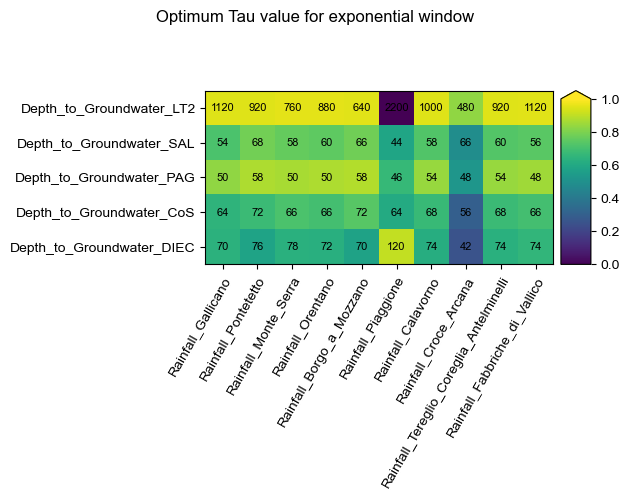

In [14]:
# Calculating optimum tau for each rainfall/target combination that
# maximises the Spearman's Rank correlation coefficient

rain_tau = find_all_best_tau(rain_ts, rain_name, target_ts, target_name)


In [15]:
# Remove 'Rainfall_Piaggione' from pre-processed data list due to missing values
rain_filt = rain_ts.copy()
rain_name_pp = rain_name.copy()
del rain_filt[5]
del rain_name_pp[5]

# Create 3 different sets of pre-processed data
#   - rain_pp_shallow is a list of size (num selected rain), where each element is a time series array. This
#     array is just for the cross-correlation anaysis, so tau value is an average value of the best tau values for
#     the shallow groundwater variables (all but LT2).
#   - rain_pp_deep is a list of size (num selected rain), where each element is a time series array. This
#     array is just for the cross-correlation anaysis, so tau value is the best tau values for the deep
#     groundwater variable (LT2).
#   - rain_pp_all is a list of size (num target variables, num selected hydro), where each element is a time
#     series array. Each array has the preprocessed data with the optimum tau value for that particular
#     combination of hydro/target. This will be used for the model.

# Rainfall data preprocessing
rain_pp_shallow = []
rain_pp_deep = []
rain_pp_all = []
for n in range(len(rain_filt)):
    tau_shallow = np.mean(rain_tau[1:, n])
    tau_deep = np.mean(rain_tau[0, n])
    rain_pp_shallow.append(exp_convolve(rain_filt[n], tau_shallow))
    rain_pp_deep.append(exp_convolve(rain_filt[n], tau_deep))
    rain_pp_ = []
    for m in range(len(target_ts)):
        tau_ = rain_tau[m, n]
        rain_pp_.append(exp_convolve(rain_filt[n], tau_))
    rain_pp_all.append(rain_pp_)


### Volume
Initial inspection of the 'volume' data showed the following:
- There is a relatively strong weekly pattern, and typically step changes every month. These are presumably linked to human activity/demand, and similar patterns are not clearly visible in the 'depth to groundwater' target variables. This suggests that it may be helpful to apply some smoothing to the volume data prior to modelling, in order to reduce the effect of the weekly/monthly variation.
- There are some very long timescale trends in the ampltidue, for example both Volume_CC1 and Volume_CC2 both increase gradually over the whole time period of the data. This timescale of change (perhaps linked to human activity/demand changes) is not present in the depth to groundwater variables, so there may be some benefit in removing it from the volume data prior to modelling.

In order to try to make the volume data more useful for modelling depth to groundwater, the following pre-processing was proposed based on the findings above:
- Caclulate the deviation of the volume data from a smoothed version of the data. The smoothed version of the data should be created with a relatively long smoothing window so that it represents the long term trend of the volume data.
- Apply some smoothing to the deviation calculated above, with a relatively short smoothing window, in order to reduce the effect of the weekly/monthly variation.

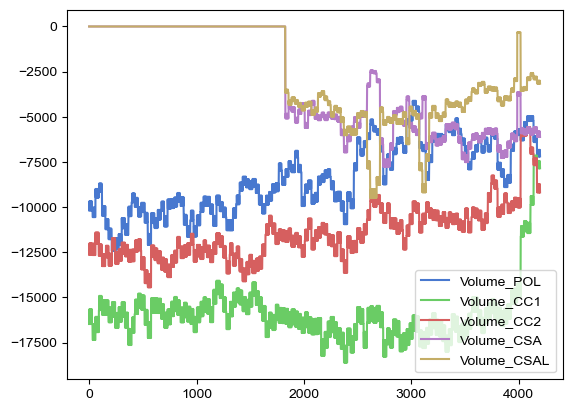

In [16]:
# Plot all volume data - for reference, not for final notebook

plt.figure()
for n in range(len(vol_ts)):
    plt.plot(vol_ts[n], label=vol_name[n])
plt.legend()
plt.show()
    

In [17]:
# Volume pre-processing

# find_best_vol_params(vol_ts[0], np.sum(target_ts, 0), smoothing_1=None, smoothing_2=None, plot=True)
# find_best_vol_params(vol_ts[0], np.sum(target_ts, 0), smoothing_1=None, smoothing_2=None, plot=True)
# find_best_vol_params(vol_ts[1], np.sum(target_ts, 0), smoothing_1=None, smoothing_2=None, plot=True)
# find_best_vol_params(vol_ts[2], np.sum(target_ts, 0), smoothing_1=None, smoothing_2=None, plot=True)

vol_pp = []
for n in range(len(vol_ts)):
    vol_pp.append(preprocess_vol(vol_ts[n]))


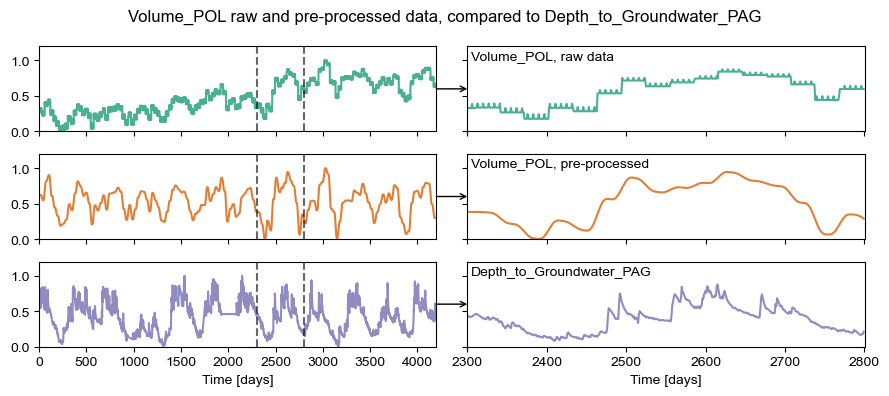

In [18]:
# Plot comparing original and pre-processed volume data

v_i = 0
t_i = 2
plot_preprocessing(vol_ts[v_i], vol_pp[v_i], vol_name[v_i], target_ts[t_i], target_name[t_i],
                   crop_min=2300, crop_max=2800, title=None)


### Temperature
All of the temperature variables appear to be reasonably well correlated to each other, showing similar seasonal variation.
However, 'Temperature_Lucca_Orto_Botanico' has long periods of missing data, including the most recent ~1000 days, so it will not be used for the machine learning model.

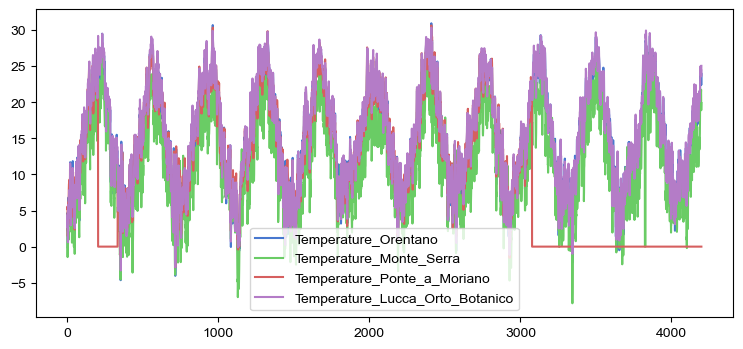

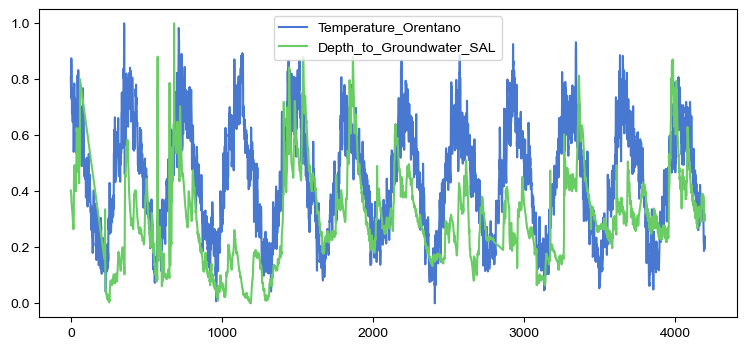

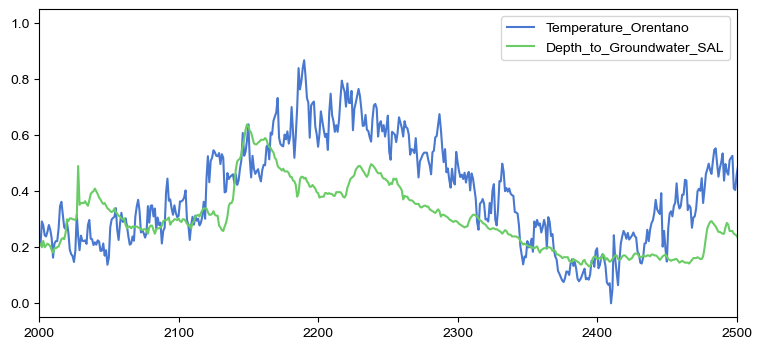

In [19]:
# Plot all temp data - for reference, not for final notebook

plt.figure(figsize=(9, 4))
for n in range(len(temp_ts)):
    plt.plot(temp_ts[n], label=temp_name[n])
plt.legend()
plt.show()

plt.figure(figsize=(9, 4))
plt.plot(normalise_0_to_1(-temp_ts[0]), label=temp_name[0])
plt.plot(normalise_0_to_1(target_ts[1]), label=target_name[1])
# plt.xlim(2000, 2500)
plt.legend()
plt.show()
plt.figure(figsize=(9, 4))
plt.plot(normalise_0_to_1(-temp_ts[0]), label=temp_name[0])
plt.plot(normalise_0_to_1(target_ts[1]), label=target_name[1])
plt.xlim(2000, 2500)
plt.legend()
plt.show()


In [20]:
# Remove 'Temperature_Lucca_Orto_Botanico' from pre-processed data list
temp_pp = temp_ts.copy()
temp_name_pp = temp_name.copy()
del temp_pp[2]
del temp_name_pp[2]


### Hydrometry

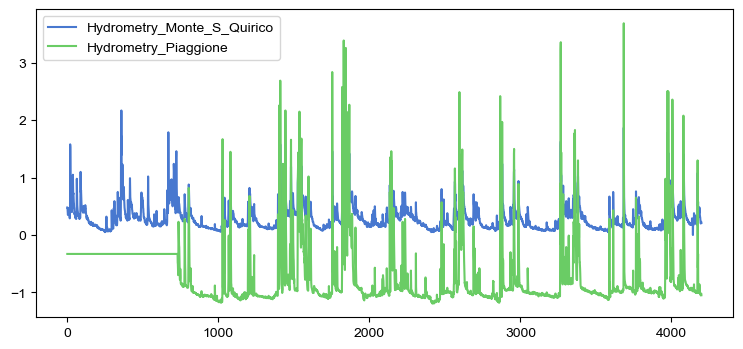

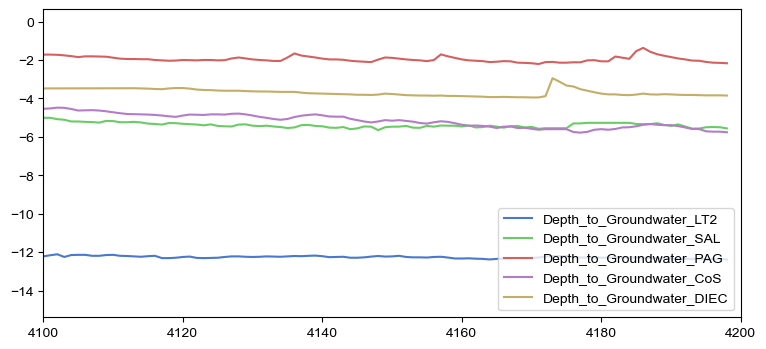

In [21]:
# Plot all hydrometry data - for reference, not for final notebook

plt.figure(figsize=(9, 4))
for n in range(len(hydro_ts)):
    plt.plot(hydro_ts[n], label=hydro_name[n])
plt.legend()
plt.show()

plt.figure(figsize=(9, 4))
for n in range(len(target_ts)):
    plt.plot(target_ts[n], label=target_name[n])
plt.xlim(4100, 4200)
plt.legend()
plt.show()


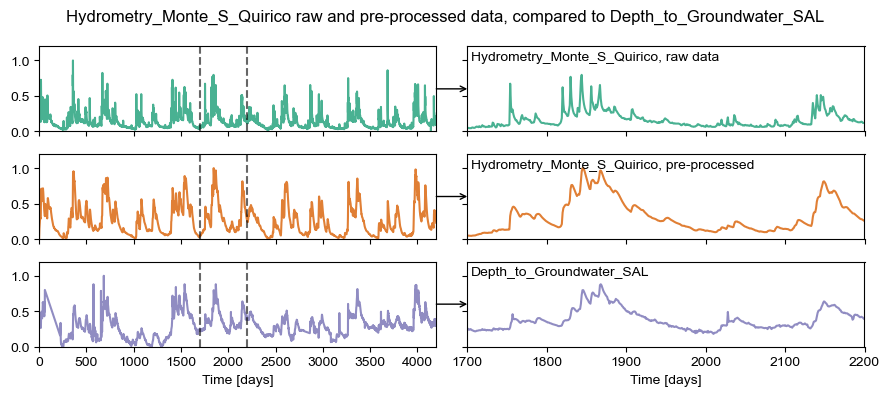

In [22]:
# Plot showing comparison of raw hydrometry data with pre-processed (smoothed) data

h_i = 0
t_i = 1
hydro_pp = exp_convolve(hydro_ts[h_i], tau=7, winlength=None)
plot_preprocessing(hydro_ts[h_i], hydro_pp, hydro_name[h_i], target_ts[t_i], target_name[t_i],
                   crop_min=1700, crop_max=2200, title=None)


<ipython-input-6-b223f7683972>:105: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ms = ax.imshow(all_src_best, norm=norm, cmap='viridis',


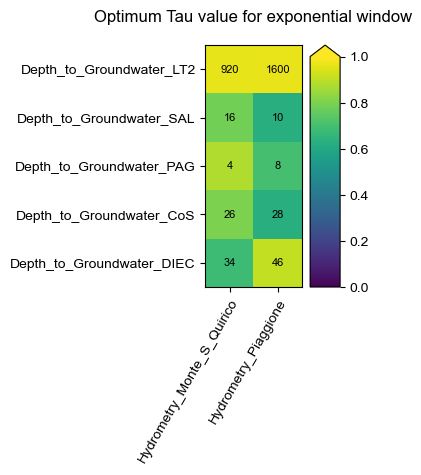

In [23]:
# Calculating optimum tau for each hydrometry/target combination that
# maximises the Spearman's Rank correlation coefficient

hydro_tau = find_all_best_tau(hydro_ts, hydro_name, target_ts, target_name)


In [24]:
# Hydrometry data preprocessing

# Remove Piaggione from data list due to missing values
hydro_filt = hydro_ts.copy()
hydro_name_pp = hydro_name.copy()
del hydro_filt[1]
del hydro_name_pp[1]

# Create 3 different sets of pre-processed data
#   - hydro_pp_shallow is a list of size (num selected hydro = 1), where each element is a time series array. This
#     array is just for the cross-correlation anaysis, so tau value is an average value of the best tau values for
#     the shallow groundwater variables (all but LT2).
#   - hydro_pp_deep is a list of size (num selected hydro = 1), where each element is a time series array. This
#     array is just for the cross-correlation anaysis, so tau value is the best tau values for the deep
#     groundwater variable (LT2).
#   - hydro_pp_all is a list of size (num target variables, num selected hydro), where each element is a time
#     series array. Each array has the preprocessed data with the optimum tau value for that particular
#     combination of hydro/target. This will be used for the model.

hydro_pp_shallow = []
hydro_pp_deep = []
hydro_pp_all = []
for n in range(len(hydro_filt)):
    tau_shallow = np.mean(hydro_tau[1:, n])
    tau_deep = np.mean(hydro_tau[0, n])
    hydro_pp_shallow.append(exp_convolve(hydro_filt[n], tau_shallow))
    hydro_pp_deep.append(exp_convolve(hydro_filt[n], tau_deep))
    hydro_pp_ = []
    for m in range(len(target_ts)):
        tau_ = hydro_tau[m, n]
        hydro_pp_.append(exp_convolve(hydro_filt[n], tau_))
    hydro_pp_all.append(hydro_pp_)


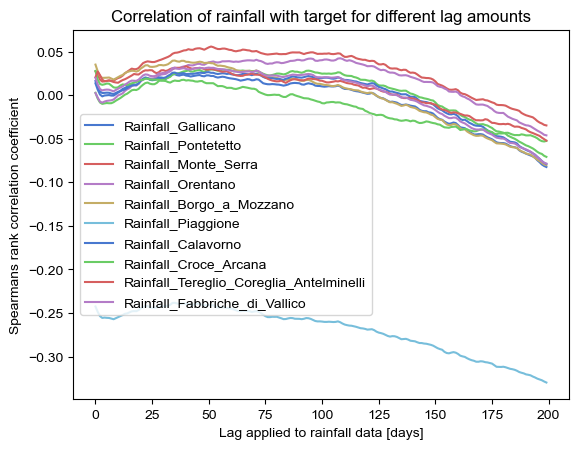

<ipython-input-6-b223f7683972>:176: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [25]:
# Analysis of how lag applied to rainfall affects correlation with target

lag_array = np.arange(200)
plt.figure()
for n in range(len(rain_ts)):
    crosscorr_lag, lag_array = cross_corr_lag(
                                    normalise_0_to_1(target_ts[0]),
                                    normalise_0_to_1(rain_ts[n]),
                                    lag_array=lag_array)
    plt.plot(lag_array, crosscorr_lag, label=rain_name[n])
plt.legend()
plt.xlabel('Lag applied to rainfall data [days]')
plt.ylabel('Spearman''s rank correlation coefficient')
plt.title('Correlation of rainfall with target for different lag amounts')
plt.show()

    

target_test_ind = 0
rain_test_ind = 0
# lag_array = np.arange(30)
# tau_array = np.linspace(12, 90, 40).astype(np.int)
lag_array = np.linspace(0, 60, 31).astype(np.int)
tau_array = np.linspace(40, 2000, 50).astype(np.int)
data1 = target_ts[target_test_ind]
data2 = rain_ts[rain_test_ind]
sp_rank_cc, lag_array, tau_array = tau_and_lag_correl(data1,
                                                      data2,
                                                      lag_array=lag_array,
                                                      tau_array=tau_array,
                                                      plot=True)


### Data down-selection
Since many of the variables seem to show a high correlation with each other, using all of them to train the model is likely to add unnecessary computation time, without improvement over a model trained with a smaller selection of variables. Therefore, some down-selection of variables was carried out prior to modelling, in order to make the machine learning model as computationally efficient as possible. This was done by calculating the cross-correlation of the pre-processed data, and evaluating the expected usefulness of each variable based on the following principles:
1. If input variables have a strong correlation to the target variable, they are likely to be useful in training the model.
2. If input variables have a strong correlation with other input variables, there may be limited benefit in including all of them in the model.

During the pre-processing of the rainfall and hydrometry data, it was found that for 'Depth_to_Groundwater_LT2', the optimum time constant (tau) for the convolution was much higher than the optimum value for the other groundwater variables. This was thought to be because the LT2 sub-system is significantly deeper underground than the other variables, and therefore it takes longer for the other variables to impact the level. In order to best evaluate the correlation of the variables, two different correlation matrices were calculated: one with variable pre-processing optimised for the shallower groundwater variables; and one with variable pre-processing optimised for the deepest groundwater variable LT2.

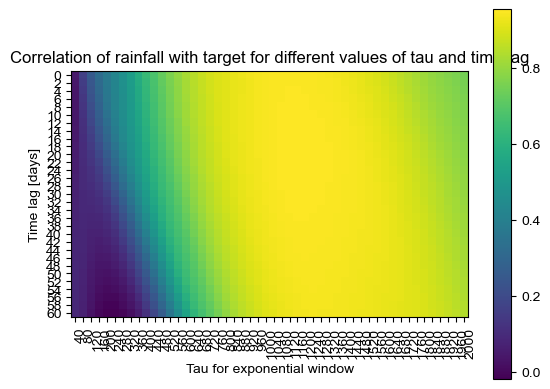

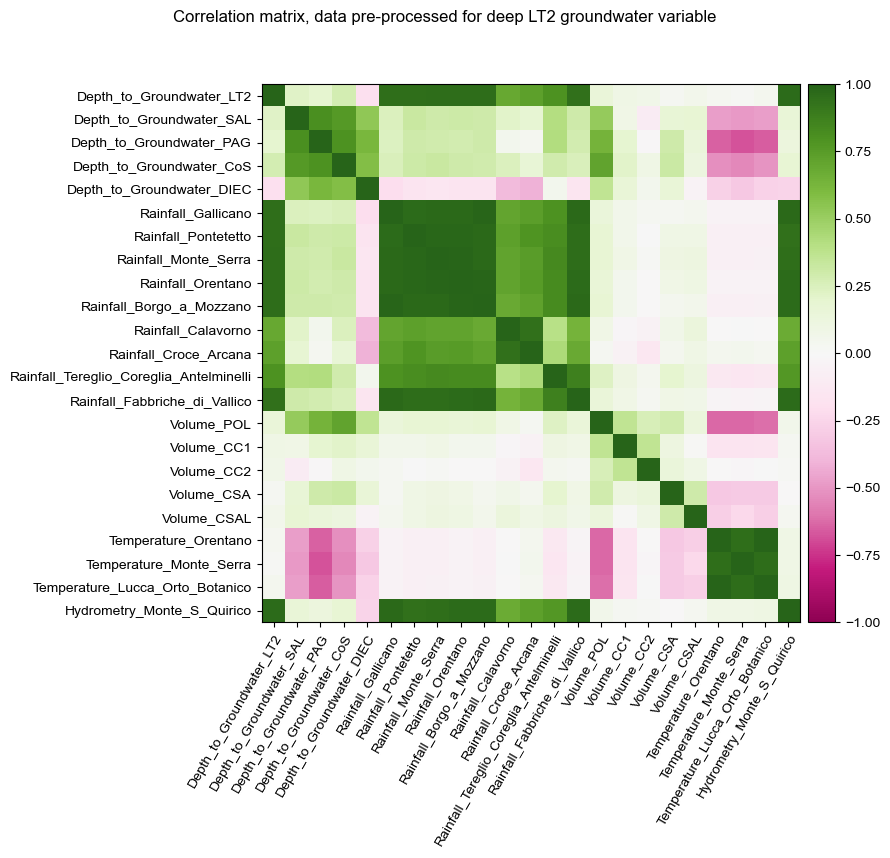

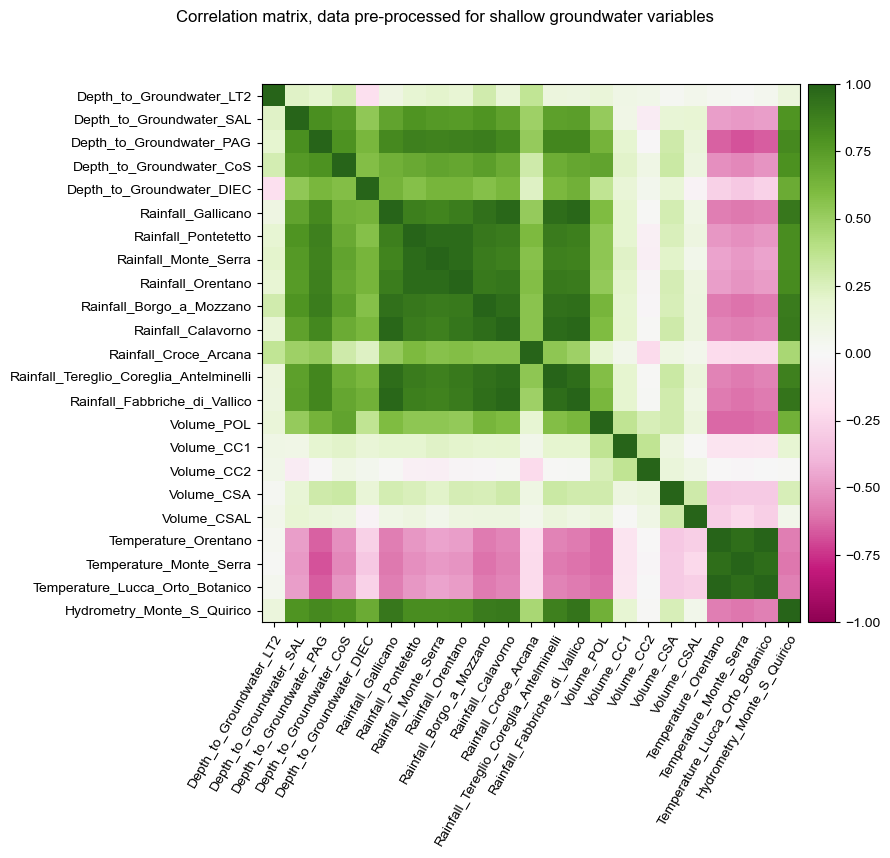

In [26]:
# Plot correlation matrices

# Combine all pre-processed data for the shallow groundwater variables
data_pp_shallow = np.concatenate((np.asarray(target_ts),
                                  np.asarray(rain_pp_shallow),
                                  np.asarray(vol_pp),
                                  np.asarray(temp_pp),
                                  np.asarray(hydro_pp_shallow)))
name_pp_shallow = target_name + rain_name_pp + vol_name + temp_name_pp + hydro_name_pp

# Combine all pre-processed data for the deep groundwater variables
data_pp_deep = np.concatenate((np.asarray(target_ts),
                               np.asarray(rain_pp_deep),
                               np.asarray(vol_pp),
                               np.asarray(temp_pp),
                               np.asarray(hydro_pp_deep)))
name_pp_deep = target_name + rain_name_pp + vol_name + temp_name_pp + hydro_name_pp

# Plot correlation matrices
plot_correl_matrix(data_pp_deep, name_pp_deep,
                   title='Correlation matrix, data pre-processed for deep LT2 groundwater variable')
plot_correl_matrix(data_pp_shallow, name_pp_shallow,
                   title='Correlation matrix, data pre-processed for shallow groundwater variables')


Model_data shape: (2, 4199)


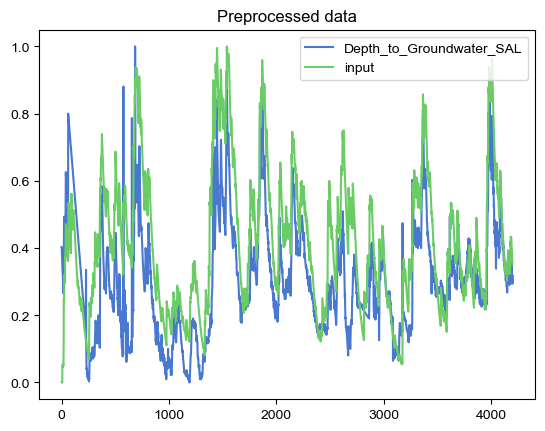

x shape: (83, 30, 2)
y shape: (83, 20)


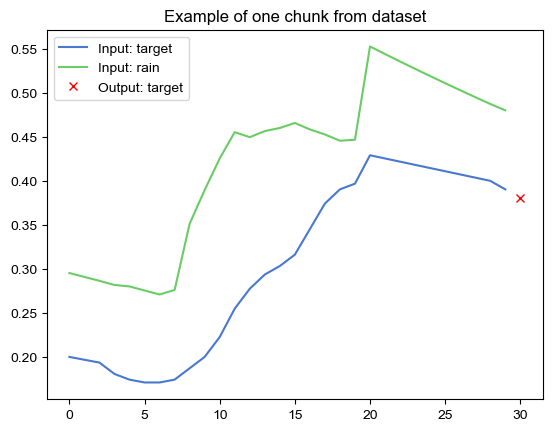

Epoch 1/30
11/11 [==============================] - 1s 4ms/step - loss: 0.1101
Epoch 2/30
11/11 [==============================] - 0s 4ms/step - loss: 0.1210
Epoch 3/30
11/11 [==============================] - 0s 4ms/step - loss: 0.1101
Epoch 4/30
11/11 [==============================] - 0s 3ms/step - loss: 0.0914
Epoch 5/30
11/11 [==============================] - 0s 3ms/step - loss: 0.1005
Epoch 6/30
11/11 [==============================] - 0s 3ms/step - loss: 0.0669
Epoch 7/30
11/11 [==============================] - 0s 4ms/step - loss: 0.0555
Epoch 8/30
11/11 [==============================] - 0s 3ms/step - loss: 0.0570
Epoch 9/30
11/11 [==============================] - 0s 4ms/step - loss: 0.0473
Epoch 10/30
11/11 [==============================] - 0s 4ms/step - loss: 0.0338
Epoch 11/30
11/11 [==============================] - 0s 4ms/step - loss: 0.0559
Epoch 12/30
11/11 [==============================] - 0s 3ms/step - loss: 0.0343
Epoch 13/30
11/11 [==============================

In [27]:
# LSTM analysis

def run_LSTM(target_data, input_data, look_back=30, chunk_step=50, train_ratio=0.67,
             num_epochs=30, batch_size=5, predict_steps=15, plot=True, verbose=1):
    """
    Wrapper function for LSTM
    
    Add in option to not use target variable?
    I haven't really thought about what would be useful outputs yet
    
    """
    # # Calculate differential of target & rainfall
    # target_diff = np.diff(target_ts[target_ind])
    # rain_conv_diff = []
    # for n in range(len(rain_pp_all[target_ind])):
    #     rain_conv_diff.append(np.diff(rain_pp_all[target_ind][n]))

    # Normalize the target dataset
    # target_ts[target_ind] = target_ts[target_ind][1:] #for diff
    target_data = np.reshape(target_data, (target_data.size, 1))
    # scaler = MinMaxScaler(feature_range=(-1, 1)) #for diff
    scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaled = scaler.fit_transform(target_data)
    target_scaled = np.squeeze(target_scaled)

    # Normalise the input variables
    num_input = model_input_data.shape[0]
    input_data_scaled = np.empty(input_data.shape)
    for n in range(num_input):
        input_data_scaled[n, :] = normalise_0_to_1(input_data[n, :])

    # Combine target and inputs into single array
    num_timesteps = target_data.size
    model_data = np.empty((num_input + 1, num_timesteps))
    model_data[0, :] = target_scaled
    model_data[1:, :] = input_data_scaled
    # model_data = np.vstack((target_scaled, input_scaled))
    print('Model_data shape: {}'.format(model_data.shape))

    # Plot preprocessed data
    if plot:
        plt.figure()
        plt.plot(model_data[0, :], label=target_name[target_ind])
        plt.plot(model_data[1, :], label='input')
        plt.legend()
        plt.title('Preprocessed data')
        plt.show()

    # Split data into chunks with random order
    x, y, y_ind = create_dataset(model_data, look_back=look_back,
                                 chunk_step=chunk_step, predict_steps=predict_steps)
    numchunk = y.shape[0]
    print('x shape: {}'.format(x.shape))
    print('y shape: {}'.format(y.shape))

    # split into train and test sets
    train_size = int(numchunk * train_ratio)
    test_size = numchunk - train_size
    trainX, testX = x[0:train_size, :, :], x[train_size:numchunk, :, :]
    trainY, testY = y[0:train_size, :], y[train_size:numchunk, :]
    trainYind, testYind = y_ind[0:train_size], y_ind[train_size:numchunk]

    # Plot one example of chunk
    if plot:
        sample_num = 0
        plt.figure()
        time_ = np.arange(look_back)
        plt.plot(time_, trainX[sample_num, :, 0], label='Input: target')
        plt.plot(time_, trainX[sample_num, :, 1], label='Input: rain')
        plt.plot([look_back], trainY[sample_num, 0], 'xr', label='Output: target')
        plt.legend()
        plt.title("Example of one chunk from dataset")
        plt.show()

    # create and fit the LSTM network
    num_features = x.shape[2]
    model = Sequential()
    model.add(LSTM(4, input_shape=(look_back, num_features)))
    model.add(Dense(predict_steps))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=num_epochs, batch_size=batch_size, verbose=verbose)

    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(trainY)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY)

    # # Convert from diff to actual prediction
    # for n in range(train_size):
    #     prev_day = target_ts[target_ind][trainYind[n] - 1]
    #     trainY[n] = prev_day + trainY[n]
    #     trainPredict[n] = prev_day + trainPredict[n]
    # for n in range(test_size):
    #     prev_day = target_ts[target_ind][testYind[n] - 1]
    #     testY[n] = prev_day + testY[n]
    #     testPredict[n] = prev_day + testPredict[n]

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[:, 0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    
    return trainScore, testScore, testYind, testPredict, trainYind, trainPredict


# Choose variables to include in model by their indices
target_ind = 1
model_rain_ind = [1]
model_vol_ind = []
model_temp_ind = []
model_hydro_ind = []


# Compile target data and inputs to model
target_data = target_ts[target_ind]
model_input_data = compile_model_input_variables(model_rain_ind,
                                                 model_vol_ind,
                                                 model_temp_ind,
                                                 model_hydro_ind,
                                                 rain_pp_all[:][target_ind],
                                                 vol_pp,
                                                 temp_pp,
                                                 hydro_pp_all[0][target_ind])


# Fix random seed for reproducibility
np.random.seed(7)

# Model parameters
look_back = 30
chunk_step = 50
train_ratio = 0.67
num_epochs = 30
batch_size = 5
predict_steps = 20

# Run LSTM model
trainScore, testScore, testYind, testPredict, trainYind, trainPredict = run_LSTM(target_data,
                                                                                 model_input_data,
                                                                                 look_back=look_back,
                                                                                 chunk_step=chunk_step,
                                                                                 train_ratio=train_ratio,
                                                                                 num_epochs=num_epochs,
                                                                                 batch_size=batch_size,
                                                                                 predict_steps=predict_steps,
                                                                                 plot=True)


In [28]:
# # Plot one prediction example from test sample
# pred_sample = 4
# pred_ind = testYind[pred_sample]
# plt.figure()
# sample_t = np.linspace(pred_ind - look_back - 1, pred_ind - 1, look_back)
# sample_t = sample_t.astype(np.int)
# plt.plot(sample_t, target_ts[target_ind][sample_t[0]:sample_t[-1]])
# plt.plot(pred_ind, testPredict[pred_sample, 0], 'xr')
# plt.title("Example of one prediction from test data")
# plt.show()


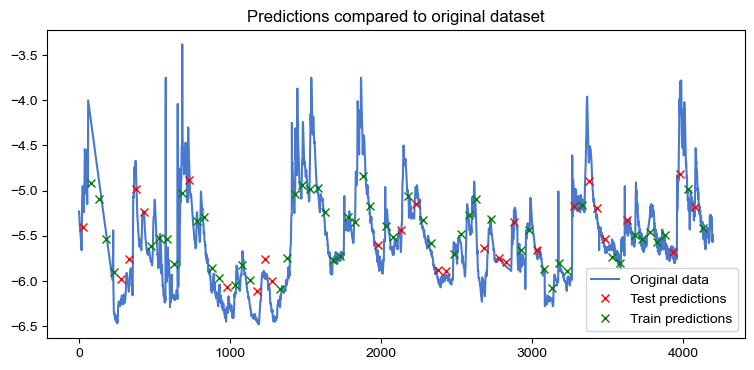

In [29]:
# Plot all predictions from test samples against original data
plt.figure(figsize=(9, 4))
plt.plot(np.linspace(0, target_data.size-1, target_data.size),
         target_data,
         label='Original data')
plt.plot(testYind, testPredict[:, 0], 'xr', label='Test predictions')
plt.plot(trainYind, trainPredict[:, 0], 'xg', label='Train predictions')
plt.legend()
plt.title("Predictions compared to original dataset")
plt.show()


## Predictability horizon

Here we evaluate the performance of the model as a function of the number of days in advance it predicts. As expected, the performance tails off with the number of days, but remains above 90% for over 15 days. 

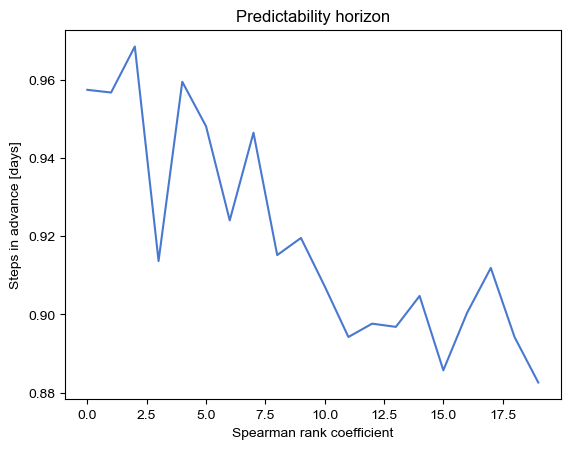

In [30]:

def get_predict_horizon(target_data, testPredict, testYind, predict_steps):
    testTarget = np.empty(np.shape(testPredict))
    for ii in range(len(testYind)):
        testTarget[ii,:] = target_data[testYind[ii]:testYind[ii] + predict_steps]
    #predict_horizon_R2 = [rsquared(testTarget[:,ii], testPredict[:,ii]) for ii in range(predict_steps)]
    predict_horizon = [spearman_lag(testTarget[:,ii], testPredict[:,ii], 0) for ii in range(predict_steps)]
    return predict_horizon

predict_horizon = get_predict_horizon(target_data, testPredict, testYind, predict_steps)

plt.figure()
plt.plot(np.arange(0, predict_steps), predict_horizon)
plt.title("Predictability horizon")
plt.xlabel("Spearman rank coefficient")
plt.ylabel("Steps in advance [days]")
plt.show()

## Weekly analysis 

Model_data shape: (2, 599)


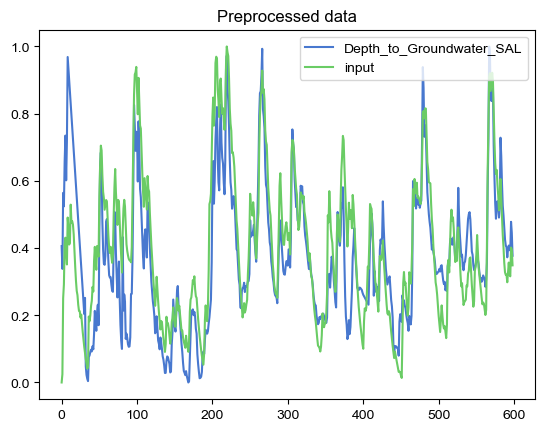

x shape: (11, 30, 2)
y shape: (11, 20)


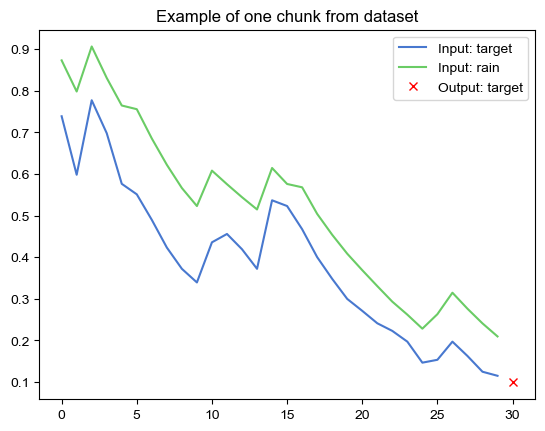

Epoch 1/30
2/2 [==============================] - 1s 9ms/step - loss: 0.1014
Epoch 2/30
2/2 [==============================] - 0s 8ms/step - loss: 0.0985
Epoch 3/30
2/2 [==============================] - 0s 6ms/step - loss: 0.0979
Epoch 4/30
2/2 [==============================] - 0s 5ms/step - loss: 0.0964
Epoch 5/30
2/2 [==============================] - 0s 6ms/step - loss: 0.0959
Epoch 6/30
2/2 [==============================] - 0s 5ms/step - loss: 0.0899
Epoch 7/30
2/2 [==============================] - 0s 6ms/step - loss: 0.0916
Epoch 8/30
2/2 [==============================] - 0s 6ms/step - loss: 0.0869
Epoch 9/30
2/2 [==============================] - 0s 6ms/step - loss: 0.0845
Epoch 10/30
2/2 [==============================] - 0s 6ms/step - loss: 0.0809
Epoch 11/30
2/2 [==============================] - 0s 5ms/step - loss: 0.0758
Epoch 12/30
2/2 [==============================] - 0s 6ms/step - loss: 0.0706
Epoch 13/30
2/2 [==============================] - 0s 5ms/step - loss: 0.

In [31]:

def get_data_mean(field, average_fac):
    """
    Calculate mean of data array along last axis. field is a vector,
    which can be more than 1D. The last dimension of field will be averaged,
    so could be shape: (num_timesteps)
    or shape: (num features, num_timesteps)
    The output will be an array with the same number of dimensions as
    field, but with the size of the last axis reduced depending on the
    averaging amount 'average_fac'.
    """
    num_dim = field.ndim
    num_timesteps = field.shape[-1]
    num_av = np.int(np.floor(num_timesteps / average_fac))
    
    # Get shape for temporary reshaped array
    if num_dim > 1:
        feature_shape = list(field.shape[:-1])
        tmp_shape = feature_shape + [num_av, average_fac]
    else:
        tmp_shape = [num_av, average_fac]
        
    # Remove earliest timesteps if num_timesteps is not divisible by average_fac
    field_crop = np.delete(field, np.s_[: -num_av*average_fac], axis=-1)
    
    # Take mean of data
    tmp = np.reshape(field_crop, tmp_shape)
    data_mean = np.mean(tmp, axis=-1)
    
    return data_mean


# # Uncomment this bit to choose different variables for weekly study:

# # Choose variables to include in model by their indices
# target_ind = 1
# model_rain_ind = [1, 2, 3]
# model_vol_ind = []
# model_temp_ind = []
# model_hydro_ind = []

# # Compile target data and inputs to model
# target_data = target_ts[target_ind]
# model_input_data = compile_model_input_variables(model_rain_ind,
#                                                  model_vol_ind,
#                                                  model_temp_ind,
#                                                  model_hydro_ind,
#                                                  rain_pp_all[:][target_ind],
#                                                  vol_pp,
#                                                  temp_pp,
#                                                  hydro_pp_all[0][target_ind])

# Calculate 1 week average
average_fac = 7
target_data_weekly = get_data_mean(target_data, average_fac)
input_data_weekly = get_data_mean(model_input_data, average_fac)

# Checking averaging
# print('target_data_weekly shape: {}'.format(target_data_weekly.shape))
# print('input_data_weekly shape: {}'.format(input_data_weekly.shape))
# plt.figure()
# plt.plot(np.arange(0, 70, 1), target_data[:70])
# plt.plot(np.arange(0, 70, average_fac), target_data_weekly[:10])
# plt.show()

# Model parameters
look_back = 30
chunk_step = 50
train_ratio = 0.67
num_epochs = 30
batch_size = 5
predict_steps = 20

# Run LSTM model with weekly average data
trainScore_weekly, testScore_weekly, testYind_weekly, testPredict_weekly, \
trainYind_weekly, trainPredict_weekly = run_LSTM(target_data_weekly,
                                                 input_data_weekly,
                                                 look_back=look_back,
                                                 chunk_step=chunk_step,
                                                 train_ratio=train_ratio,
                                                 num_epochs=num_epochs,
                                                 batch_size=batch_size,
                                                 predict_steps=predict_steps,
                                                 plot=True)


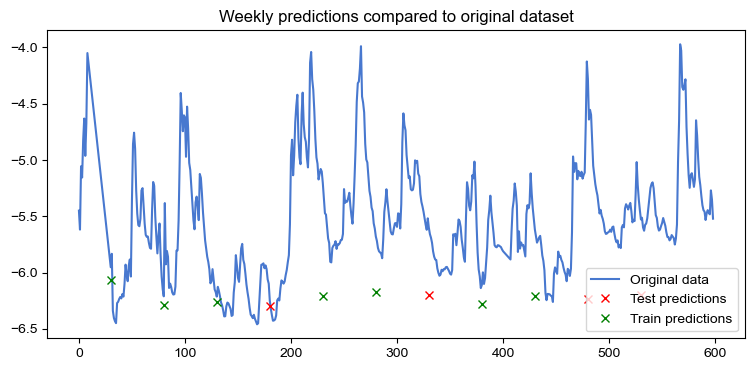

In [32]:
# Plot all weekly predictions from test samples against original data
plt.figure(figsize=(9, 4))
plt.plot(np.linspace(0, target_data_weekly.size-1, target_data_weekly.size),
         target_data_weekly,
         label='Original data')
plt.plot(testYind_weekly, testPredict_weekly[:, 0], 'xr', label='Test predictions')
plt.plot(trainYind_weekly, trainPredict_weekly[:, 0], 'xg', label='Train predictions')
plt.legend()
plt.title("Weekly predictions compared to original dataset")
plt.show()

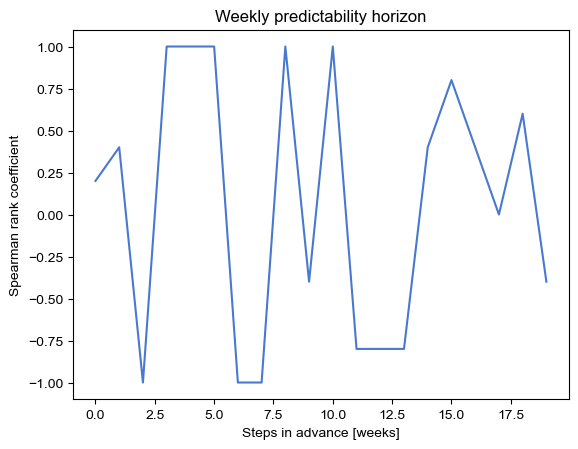

In [33]:
# MG: something weird happening here..Probably taking the wrong inputs

predict_horizon_weekly = get_predict_horizon(target_data_weekly, testPredict_weekly, testYind_weekly, predict_steps)

plt.figure
plt.plot(np.arange(0,predict_steps), predict_horizon_weekly)
plt.title("Weekly predictability horizon")
plt.ylabel("Spearman rank coefficient")
plt.xlabel("Steps in advance [weeks]")
plt.show()